In [1]:
from torch import cuda
import torch
cuda.get_device_properties()

_CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16144MB, multi_processor_count=80, uuid=e845d646-3c94-b57c-8547-b376f9dd4850, pci_bus_id=26, pci_device_id=0, pci_domain_id=0, L2_cache_size=6MB)

### inspect trained models

In [27]:
import torch
from train_ft import FreeTransformer, FreeTransformerConfig, enc

# Load checkpoint
checkpoint_path = '/SEAS/home/g21775526/code/aladdin/outputs/2.2_20251030_085832/log/model_05000_steps_2.8212_loss.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Create model with saved config
config = checkpoint['config']
model = FreeTransformer(config)

# Load model weights
model.load_state_dict(checkpoint['model'])

# Move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

print(f"Loaded model from step {checkpoint['step']}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")

# Now you can use the model for inference
# with torch.no_grad():
#     output = model(input_tokens)

Loaded model from step 5000
Validation loss: 2.8212


In [28]:
import torch

# Assuming 'model' is your PyTorch model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 141892616
Trainable parameters: 141892616


In [29]:
# generate from model checkpoint
import tiktoken
from torch.nn import functional as F

model.load_state_dict(checkpoint['model'])
model.eval()
num_return_sequences = 5
max_length = 64
tokens = enc.encode("س: لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الخفيفة على الأرض؟ ج:")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)

while xgen.size(1) < max_length:
    with torch.no_grad():
        with torch.autocast(device_type='cpu', dtype=torch.bfloat16):
            logits, loss = model(xgen) # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        xgen = torch.cat((xgen, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"sample {i}: {decoded}")

sample 0: س: لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الخفيفة على الأرض؟ ج: إذا كانت هذه الأمور هي الحقيقة
منسوباخبارالعمرانالولايات المتحدة
لقد قمنا بتحديث نظام التعليقات على موقعنا ونأمل أن ينال إعجابكم لكتابة التعليقات يجب أولا التسجيل عن طريق مواقع التواصل الاجتماعي أو عن طريق خدمة البريد
sample 1: س: لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الخفيفة على الأرض؟ ج: لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة
 لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام
sample 2: س: لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الخفيفة على الأرض؟ ج: لماذا لا تسقط الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أسرع من الأجسام الثقيلة أكبر بكثير من الأجسام الثقيلة أكبر بكثير من الأجسام المختلفة أقل من الأجسام الخفيفة أكبر بكثير م

In [15]:
# generate from model checkpoint
import tiktoken
from torch.nn import functional as F

model.load_state_dict(checkpoint['model'])
model.eval()
num_return_sequences = 1
max_length = 512
tokens = enc.encode("هل")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)

while xgen.size(1) < max_length:
    with torch.no_grad():
        with torch.autocast(device_type='cpu', dtype=torch.bfloat16):
            logits, loss = model(xgen) # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        xgen = torch.cat((xgen, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"sample {i}: {decoded}")

sample 0: هل انتحر حرق كنترول فى الهواء حرق قلبى حرق كبده مع شويه اصابعه يا روحى وولعت فوق دماغك ياخوياواضح ان لوفي حرق عليك القنبله ولا لاما اتوقع ان ايرين هو العملاق الي ظهر في الحلقه الاخيره زي هذي كانت البدايه جداامبارح في شارع البديع تم حرق مبنى مكتب الارشاد وتم التاكيد على الخبر الي كان قبل يومين وطلع خبر على حد علمي ان في اسكان برئ بالقاهره مش بعيد كان بيعملوا ايه مع انهم كانوا نازلين يستنو من قنبله شديده من حرق مقرات الاخوان اللي بتطالب فيها بالتحقيق واعلان البراءه ان كان بيفصل الفيلم بشكل صحيح عن الاحداث في الاسماعيليهمن جدكم تدورين عن حرق السفاره الامريكيه والله ما يسكتكم الا انتم لانكم عبتكم ايران ايران الله يمهل ولايهمل والله شي مخزي يا ابو حمد انا اشوف اني اتابع وولعت في تويتر وبقرا تغريده وهذي مصيبه على الناس مااقول الا الله يجزيكم خير ويكتب لكم خيرها ويحفظكم من كل شرحرق مقار الاخوان في حلوان ده هو الحل الافضل في حرق مصرحرق في امبابه بس مافيش حد تاني مشوفتش حد ال حرق علي وقالي يامسهلهعقبال ما يتم حرق مقر الحريه والعداله بالعاصمه عدن الان عبر الرابطشبكه شباب مصر المتظاهرون

In [23]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import numpy as np

# File path (replace with the actual path to your log file)

def plot_training_loss(file):
    file_path = file
    log_data = []
    
    # Attempt to read the file
    try:
        with open(file_path, 'r') as file:
            for line in file:
                log_data.append(line.strip())  # Strip removes leading/trailing whitespace/newlines
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    # Data containers for training/validation loss and performance metrics
    train_steps = []
    train_losses = []
    val_steps = []
    val_losses = []
    performance_metrics = {}
    
    # Parse the log data
    for line in log_data:
        # Skip empty lines or lines that don't match the expected format
        if not line or len(line.split()) < 3:
            continue
        
        try:
            parts = line.split()
            step = int(parts[0])  # The step is expected to be an integer
            category = parts[1]   # 'train', 'val', or a performance metric name (e.g., 'hella')
            value = float(parts[2])  # The value is expected to be a float
    
            # Process data based on category
            if category == "train":
                train_steps.append(step)
                train_losses.append(value)
            elif category == "val":
                val_steps.append(step)
                val_losses.append(value)
            else:
                # For performance metrics (e.g., 'hella', 'arabic_mmlu', etc.)
                performance_metrics[category] = performance_metrics.get(category, [])
                performance_metrics[category].append((step, value))
        
        except ValueError:
            # Skip lines with malformed data (e.g., non-numeric values)
            print(f"Skipping malformed line: {line}")
        except Exception as e:
            # Catch any other errors during parsing
            print(f"Error processing line: {line}. Error: {e}")
    
    # Function to smooth the data using cubic splines
    def smooth_data(x, y):
        spline = CubicSpline(x, y)
        x_new = np.linspace(min(x), max(x), num=500)  # Generate new x values for smooth curve
        y_new = spline(x_new)  # Get the smoothed y values
        return x_new, y_new
    
    # Plot training and validation loss
    plt.figure(figsize=(14, 7))  # Increase figure size for better clarity
    
    # Plot training loss
    train_steps_smooth, train_losses_smooth = smooth_data(train_steps, train_losses)
    plt.subplot(1, 2, 1)
    plt.plot(train_steps_smooth, train_losses_smooth, label='Training Loss (Smoothed)', color='blue', linewidth=1)  # Thinner line
    plt.scatter(train_steps, train_losses, color='blue', marker='o', s=20, alpha=0.5)  # Smaller points, more transparency
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot validation loss
    if val_steps:
        val_steps_smooth, val_losses_smooth = smooth_data(val_steps, val_losses)
        plt.subplot(1, 2, 2)
        plt.plot(val_steps_smooth, val_losses_smooth, label='Validation Loss (Smoothed)', color='red', linewidth=1)  # Thinner line
        plt.scatter(val_steps, val_losses, color='red', marker='o', s=20, alpha=0.5)  # Smaller points, more transparency
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Validation Loss')
        plt.grid(True)
    
    plt.tight_layout()
    
    # Show performance metrics (e.g., 'hella', 'arabic_mmlu')
    for metric, values in performance_metrics.items():
        steps, metric_values = zip(*values)
        steps_smooth, metric_values_smooth = smooth_data(steps, metric_values)
        plt.plot(steps_smooth, metric_values_smooth, label=f'{metric} Performance (Smoothed)', marker='x', markersize=6, linestyle='--', linewidth=1)  # Dotted line for metrics
    
    plt.legend()
    plt.show()


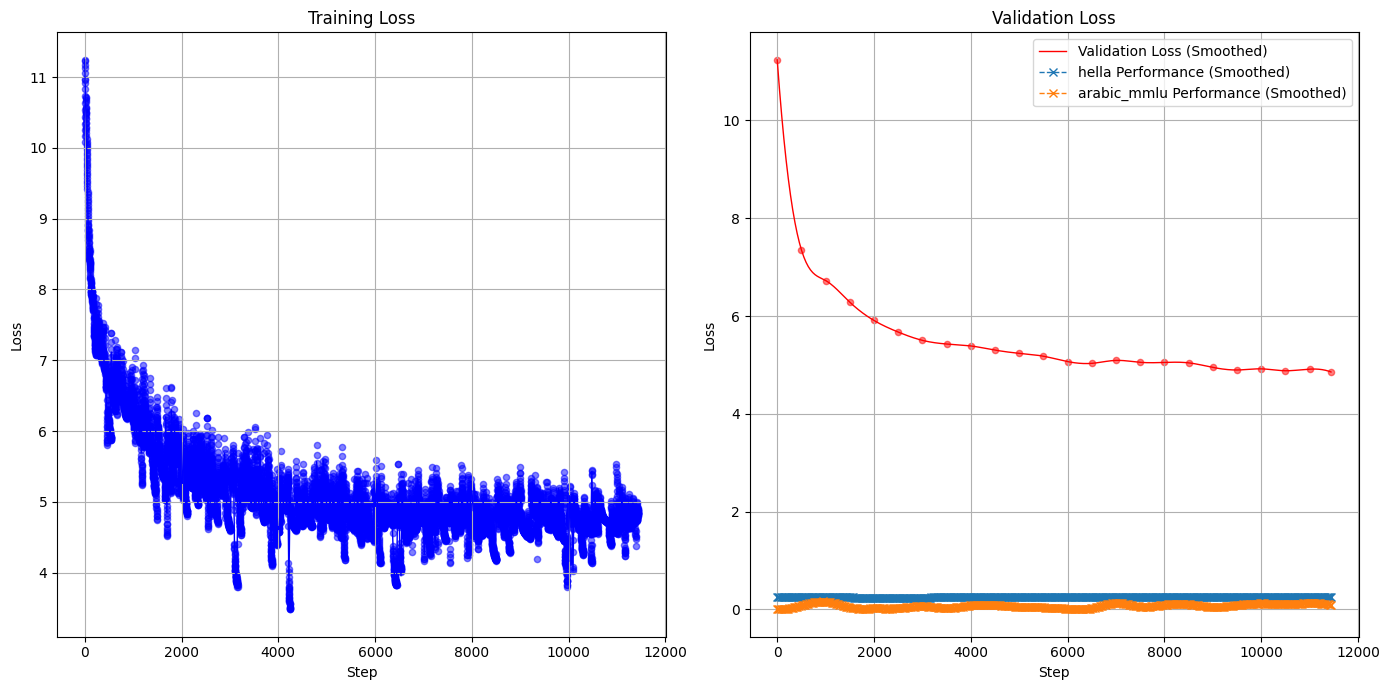

In [24]:
plot_training_loss('/SEAS/home/g21775526/code/aladdin/outputs/2.1_20251030_085930/log/log.txt')

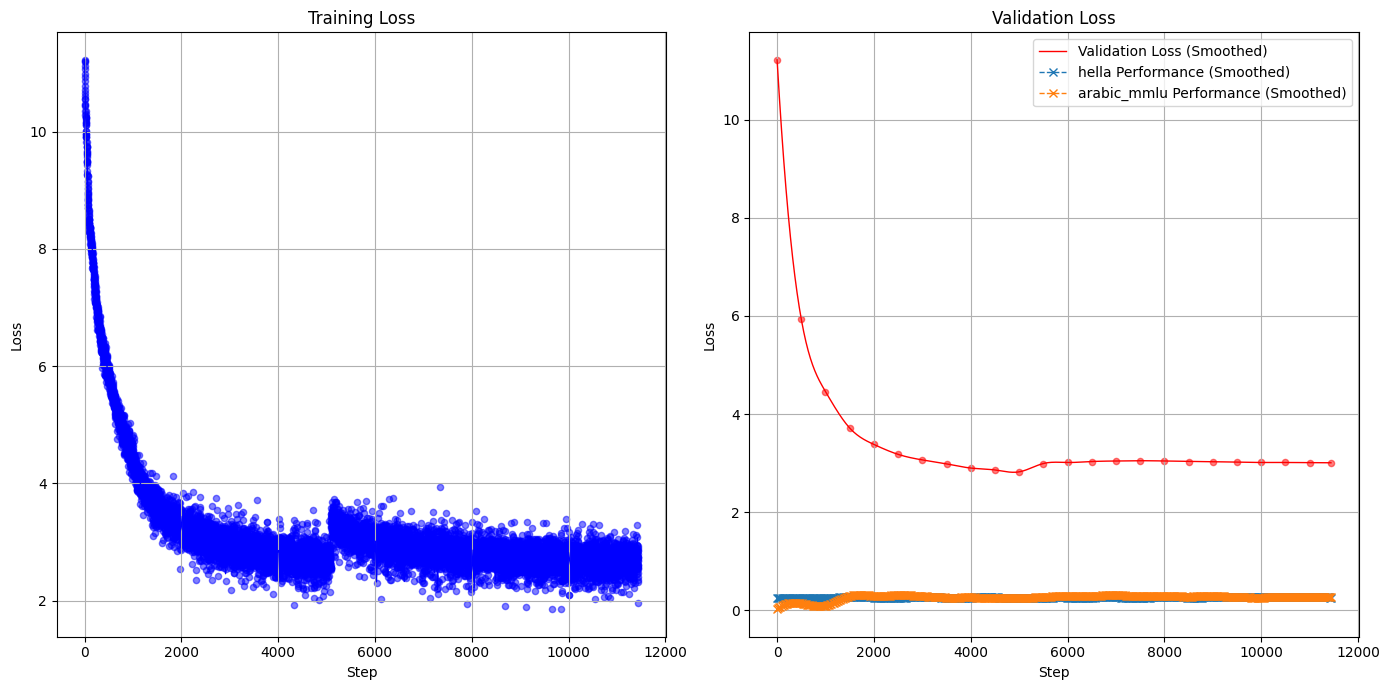

In [25]:
plot_training_loss('/SEAS/home/g21775526/code/aladdin/outputs/2.2_20251030_085832/log/log.txt')

## **Finetuning**

### prepare dataset

In [1]:
import pandas as pd
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [120]:
data_file_path = "/SEAS/home/g21775526/data/carma/cleaned_arabic_datasetv3.csv"
df = pd.read_csv(data_file_path)


CONDITION = "anxiety"


def create_balanced(df):
  df[df['condition'] == CONDITION].shape[0]
  han_subset = df[df['condition'] == 'control'].sample(n=df[df['condition'] == CONDITION].shape[0], random_state=123)
  # convert labels to int
  return pd.concat([han_subset, df[df['condition'] == CONDITION]])

balanced_df = create_balanced(df).reset_index(drop=True)
balanced_df = balanced_df[['selftext', 'condition']]
balanced_df['condition'].value_counts()

condition
control    22306
anxiety    22306
Name: count, dtype: int64

In [121]:
map_dict = {'control': 0, CONDITION: 1}
balanced_df['condition'] = balanced_df['condition'].map(map_dict)
# shuffle dataframe
balanced_df = balanced_df.sample(frac=1, random_state=123)
#reset index
balanced_df = balanced_df.reset_index(drop=True)
balanced_df.head()
# check specifc row



,selftext,condition
0,هو لو انا او حد في عيلتي تعب و احتاج دكتور الم...,1
1,ما شاء الله نص مصر نومها مقلوب.. تصبح على خير ...,0
2,قريب بفتح مشروع إن شاء الله ، ومحتارة أقول لأه...,1
3,انا طبيعتي شاطر اصلا و . يعني بس انا فكليه خا...,0
4,لاقيت واحد ملحد من قبل بيقول انه قال لصاحبته ه...,1


In [122]:
def random_split(df, train_frac, val_frac):
  train_end = int(len(df) * train_frac)
  val_end = int(len(df) * (train_frac + val_frac))

  return df[:train_end], df[train_end:val_end], df[val_end:]

train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.2)

train_df.to_csv(f'data/finetuning/{CONDITION}_train.csv', index=False)
val_df.to_csv(f'data/finetuning/{CONDITION}_val.csv', index=False)
test_df.to_csv(f'data/finetuning/{CONDITION}_test.csv', index=False)
train_df.shape, val_df.shape, test_df.shape



((31228, 2), (8922, 2), (4462, 2))

In [123]:
#get aranizer tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("riotu-lab/Aranizer-PBE-64k")

# Set the pad token explicitly
tokenizer.pad_token_id = 1
tokenizer.pad_token = "<pad>"

print(f"Pad token ID: {tokenizer.pad_token_id}")  # Should print: 1

import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=1):
        self.data = pd.read_csv(csv_file)

        # find pad token id for this tokenizer
      
        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["selftext"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["condition"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

Pad token ID: 1


In [124]:
train_dataset = SpamDataset(csv_file=f'data/finetuning/{CONDITION}_train.csv', max_length=512, tokenizer=tokenizer)
val_dataset = SpamDataset(csv_file=f'data/finetuning/{CONDITION}_val.csv', max_length=512, tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file=f'data/finetuning/{CONDITION}_test.csv', max_length=512, tokenizer=tokenizer)
train_dataset

In [125]:
from torch.utils.data import DataLoader

num_workers = 4
batch_size = 8

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [126]:
print('training loader:')
for input_batch, target_batch in train_loader:
  pass

print("input batch dims: ", input_batch.shape)
print("label batch dims: ", target_batch.shape)

print(f'training batches: {len(train_loader)}')
print(f'validation batches: {len(val_loader)}')

print('=' * 40)

training loader:
input batch dims:  torch.Size([8, 512])
label batch dims:  torch.Size([8])
training batches: 3903
validation batches: 1116


### edit model output layer

In [127]:
import torch
from train_ft import FreeTransformer, FreeTransformerConfig, enc

# Load checkpoint
def get_classification_moddel(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    # Create model with saved config
    config = checkpoint['config']
    model = FreeTransformer(config)

    # Load model weights
    model.load_state_dict(checkpoint['model'])

    # Move to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False  # freez model

    # replace output head
    model.lm_head = torch.nn.Linear(in_features=768, out_features=2, bias=False)

    # last transformer block
    for param in model.transformer.h[-1].parameters():
        param.requires_grad = True

    for param in model.transformer.ln_f.parameters():
        param.requires_grad = True
    
    print(f"Loaded model from step {checkpoint['step']}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    
    return model

### Finetuning metrics calculation

In [128]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits, _ = model(input_batch) # Unpack the tuple to get logits
                logits = logits[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits, _ = model(input_batch) # Unpack the tuple to get logits
    logits = logits[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [129]:
# ---------------Loss and accuracy for finetuning------------------
checkpoint_path = '/SEAS/home/g21775526/code/aladdin/outputs/2.2_20251030_085832/log/model_05000_steps_2.8212_loss.pt'
model = get_classification_moddel(str(checkpoint_path))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy= calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy= calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Loaded model from step 5000
Validation loss: 2.8212
Training accuracy: 48.75%
Validation accuracy: 56.25%
Test accuracy: 41.25%
Training loss: 0.925
Validation loss: 0.826
Test loss: 0.826


In [130]:
# ---------------finetuning on depression binary classification------------------
from sklearn.metrics import recall_score, f1_score, precision_score

def calc_metrics_loader(data_loader, model, device, num_batches=None):
    """Calculate accuracy, recall, F1, and precision"""
    model.eval()
    all_predictions = []
    all_targets = []

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            
            with torch.no_grad():
                logits, _ = model(input_batch)
                logits = logits[:, -1, :]  # Logits of last output token
            
            predicted_labels = torch.argmax(logits, dim=-1)
            
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_targets.extend(target_batch.cpu().numpy())
        else:
            break
    
    # Calculate metrics
    accuracy = sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
    recall = recall_score(all_targets, all_predictions, average='binary')
    f1 = f1_score(all_targets, all_predictions, average='binary')
    precision = precision_score(all_targets, all_predictions, average='binary')
    
    return accuracy, recall, f1, precision


def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
                            num_epochs, eval_freq, eval_iter):
    # Initialize lists to track losses and metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_acc, train_recall, train_f1, _ = calc_metrics_loader(
                    train_loader, model, device, num_batches=eval_iter
                )
                val_acc, val_recall, val_f1, _ = calc_metrics_loader(
                    val_loader, model, device, num_batches=eval_iter
                )

                train_losses.append(loss.item())
                val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
                val_losses.append(val_loss)
                
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                train_recalls.append(train_recall)
                val_recalls.append(val_recall)
                train_f1s.append(train_f1)
                val_f1s.append(val_f1)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {loss.item():.3f}, Val loss {val_loss:.3f}, "
                      f"Train acc {train_acc*100:.2f}%, Val acc {val_acc*100:.2f}%, "
                      f"Train recall {train_recall:.3f}, Val recall {val_recall:.3f}, "
                      f"Train F1 {train_f1:.3f}, Val F1 {val_f1:.3f}")

        # Print final metrics after each epoch
        train_acc, train_recall, train_f1, train_precision = calc_metrics_loader(
            train_loader, model, device
        )
        val_acc, val_recall, val_f1, val_precision = calc_metrics_loader(
            val_loader, model, device
        )
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Training   - Acc: {train_acc*100:.2f}%, Recall: {train_recall:.3f}, "
              f"F1: {train_f1:.3f}, Precision: {train_precision:.3f}")
        print(f"Validation - Acc: {val_acc*100:.2f}%, Recall: {val_recall:.3f}, "
              f"F1: {val_f1:.3f}, Precision: {val_precision:.3f}\n")

    return train_losses, val_losses, train_accs, val_accs, train_recalls, val_recalls, train_f1s, val_f1s, examples_seen

### Finetuning loop

### 2.1 run

### 2.1 run

In [133]:
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import recall_score, f1_score, precision_score
import torch.nn as nn

# Use all available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()
print(f"Using {n_gpus} GPUs")

# Directory containing checkpoint files
checkpoint_path = '/SEAS/home/g21775526/code/aladdin/outputs/2.2_20251030_085832/log/model_05000_steps_2.8212_loss.pt'


# Store results
results = []

print(f"\n{'='*80}")
print(f"Evaluating: {checkpoint_path}")
print(f"{'='*80}")

try:
    # Load model from checkpoint
    model = get_classification_moddel(str(checkpoint_path))
    
    # Add classification head
    # num_classes = 2
    # model.out_head = nn.Linear(model.config.n_embd, num_classes)
    
    # Use DataParallel to utilize all GPUs
    if n_gpus > 1:
        model = nn.DataParallel(model)
        print(f"Using DataParallel across {n_gpus} GPUs")
    
    model.to(device)
    
    # Reset optimizer for this model
    if n_gpus > 1:
        optimizer = torch.optim.AdamW([
            {'params': model.module.transformer.parameters(), 'lr': 1e-5},
            {'params': model.module.lm_head.parameters(), 'lr': 5e-5}
        ], weight_decay=0.1)
    else:
        optimizer = torch.optim.AdamW([
            {'params': model.transformer.parameters(), 'lr': 1e-5},
            {'params': model.lm_head.parameters(), 'lr': 5e-5}
        ], weight_decay=0.1)
    
    # Increase batch size for multiple GPUs
    effective_batch_size = 8 * n_gpus  # Adjust based on memory
    
    # Recreate dataloaders with larger batch size
    train_loader_multi = DataLoader(
        dataset=train_dataset,
        batch_size=effective_batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=4
    )
    
    val_loader_multi = DataLoader(
        dataset=val_dataset,
        batch_size=effective_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=4
    )
    
    test_loader_multi = DataLoader(
        dataset=test_dataset,
        batch_size=effective_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=4
    )
    
    # Train/fine-tune the model
    torch.manual_seed(123)
    train_losses, val_losses, train_accs, val_accs, train_recalls, val_recalls, train_f1s, val_f1s, examples_seen = train_classifier_simple(
        model, train_loader_multi, val_loader_multi, optimizer, device,
        num_epochs=5, eval_freq=50, eval_iter=5,
    )
    
    # Calculate final test metrics
    test_acc, test_recall, test_f1, test_precision = calc_metrics_loader(
        test_loader_multi, model, device
    )
    
    # Get final training and validation metrics
    final_train_acc, final_train_recall, final_train_f1, final_train_precision = calc_metrics_loader(
        train_loader_multi, model, device, num_batches=10
    )
    final_val_acc, final_val_recall, final_val_f1, final_val_precision = calc_metrics_loader(
        val_loader_multi, model, device, num_batches=10
    )
    
    results.append({
        'Checkpoint': checkpoint_path,
        'Train_Acc': f"{final_train_acc*100:.2f}",
        'Train_Recall': f"{final_train_recall:.3f}",
        'Train_F1': f"{final_train_f1:.3f}",
        'Train_Precision': f"{final_train_precision:.3f}",
        'Val_Acc': f"{final_val_acc*100:.2f}",
        'Val_Recall': f"{final_val_recall:.3f}",
        'Val_F1': f"{final_val_f1:.3f}",
        'Val_Precision': f"{final_val_precision:.3f}",
        'Test_Acc': f"{test_acc*100:.2f}",
        'Test_Recall': f"{test_recall:.3f}",
        'Test_F1': f"{test_f1:.3f}",
        'Test_Precision': f"{test_precision:.3f}",
    })
    
    print(f"✓ Completed: Test Acc={test_acc*100:.2f}%, Test Recall={test_recall:.3f}, Test F1={test_f1:.3f}")
    
except Exception as e:
    print(f"✗ Error processing {checkpoint_path}: {str(e)}")
    import traceback
    traceback.print_exc()

# Display results table
results_df = pd.DataFrame(results)
print(f"\n{'='*80}")
print("FINAL RESULTS - ALL METRICS")
print(f"{'='*80}")
print(results_df.to_string(index=False))

# Save to CSV
output_csv = os.path.join("results/finetuning/", f'{CONDITION}_model_2.2_05000.csv')
results_df.to_csv(output_csv, index=False)
print(f"\nResults saved to: {output_csv}")

Using 4 GPUs

Evaluating: /SEAS/home/g21775526/code/aladdin/outputs/2.2_20251030_085832/log/model_05000_steps_2.8212_loss.pt
Loaded model from step 5000
Validation loss: 2.8212
Using DataParallel across 4 GPUs
Ep 1 (Step 000000): Train loss 0.684, Val loss 0.784, Train acc 55.00%, Val acc 45.62%, Train recall 1.000, Val recall 1.000, Train F1 0.710, Val F1 0.627
Ep 1 (Step 000050): Train loss 0.676, Val loss 0.696, Train acc 53.75%, Val acc 51.25%, Train recall 0.486, Val recall 0.479, Train F1 0.493, Val F1 0.473
Ep 1 (Step 000100): Train loss 0.725, Val loss 0.696, Train acc 51.88%, Val acc 46.25%, Train recall 0.816, Val recall 0.836, Train F1 0.648, Val F1 0.587
Ep 1 (Step 000150): Train loss 0.706, Val loss 0.698, Train acc 46.25%, Val acc 48.75%, Train recall 0.882, Val recall 0.945, Train F1 0.609, Val F1 0.627
Ep 1 (Step 000200): Train loss 0.692, Val loss 0.677, Train acc 50.00%, Val acc 56.88%, Train recall 0.093, Val recall 0.110, Train F1 0.167, Val F1 0.188
Ep 1 (Step 0002

In [132]:
examples_seen

31200